In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [98]:
df = pd.read_csv("diamonds.csv")
df.head()

Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75

In [99]:
df.shape

(53940, 11)

In [100]:
df = df.drop(columns=["Unnamed: 0"], axis=1)
df = df.drop_duplicates()

In [101]:
df.shape

(53794, 10)

In [102]:
df["volume"] = df["x"] * df["y"] * df["z"]
df["aspect_ratio"] = df["x"] / df["y"]
df["carat_per_volume"] = df["carat"] / df["volume"]
df["depth_table_ratio"] = df["depth"] / df["table"]

In [103]:
category_orders = {
    "clarity": {
        "I1": 1,
        "SI2": 2,
        "SI1": 3,
        "VS2": 4,
        "VS1": 5,
        "VVS2": 6,
        "VVS1": 7,
        "IF": 8,
    },
    "cut": {
        "Fair": 1,
        "Good": 2,
        "Very Good": 3,
        "Premium": 4,
        "Ideal": 5,
    },
    "color": {
        "J": 1,
        "I": 2,
        "H": 3,
        "G": 4,
        "F": 5,
        "E": 6,
        "D": 7,
    },
}

for col, mapping in category_orders.items():
    df[col + "_encoded"] = df[col].map(mapping)

In [104]:
categorical_columns = ["cut", "color", "clarity"]

numerical_columns = [
    "carat",
    "depth",
    "table",
    "x",
    "y",
    "z",
    "volume",
    "aspect_ratio",
    "carat_per_volume",
    "depth_table_ratio",
    "cut_encoded",
    "color_encoded",
    "clarity_encoded",
]

target_column = "price"


In [105]:
df.head()

carat      cut color clarity  depth  table  price     x     y     z  \
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43   
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31   
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31   
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   

      volume  aspect_ratio  carat_per_volume  depth_table_ratio  \
0  38.202030      0.992462          0.006021           1.118182   
1  34.505856      1.013021          0.006086           0.980328   
2  38.076885      0.995086          0.006040           0.875385   
3  46.724580      0.992908          0.006207           1.075862   
4  51.917250      0.997701          0.005971           1.091379   

   clarity_encoded  cut_encoded  color_encoded  
0                2            5              6  
1                3            4              6  
2                5            2              6  
3                4            4              2  
4                2            2              1

In [106]:
df[numerical_columns + [target_column]] = df[
    numerical_columns + [target_column]
].replace([np.inf, -np.inf], np.nan)

df = df.dropna()

In [107]:
df.shape

(53775, 17)

# EDA

## Numerical EDA

### Histograms

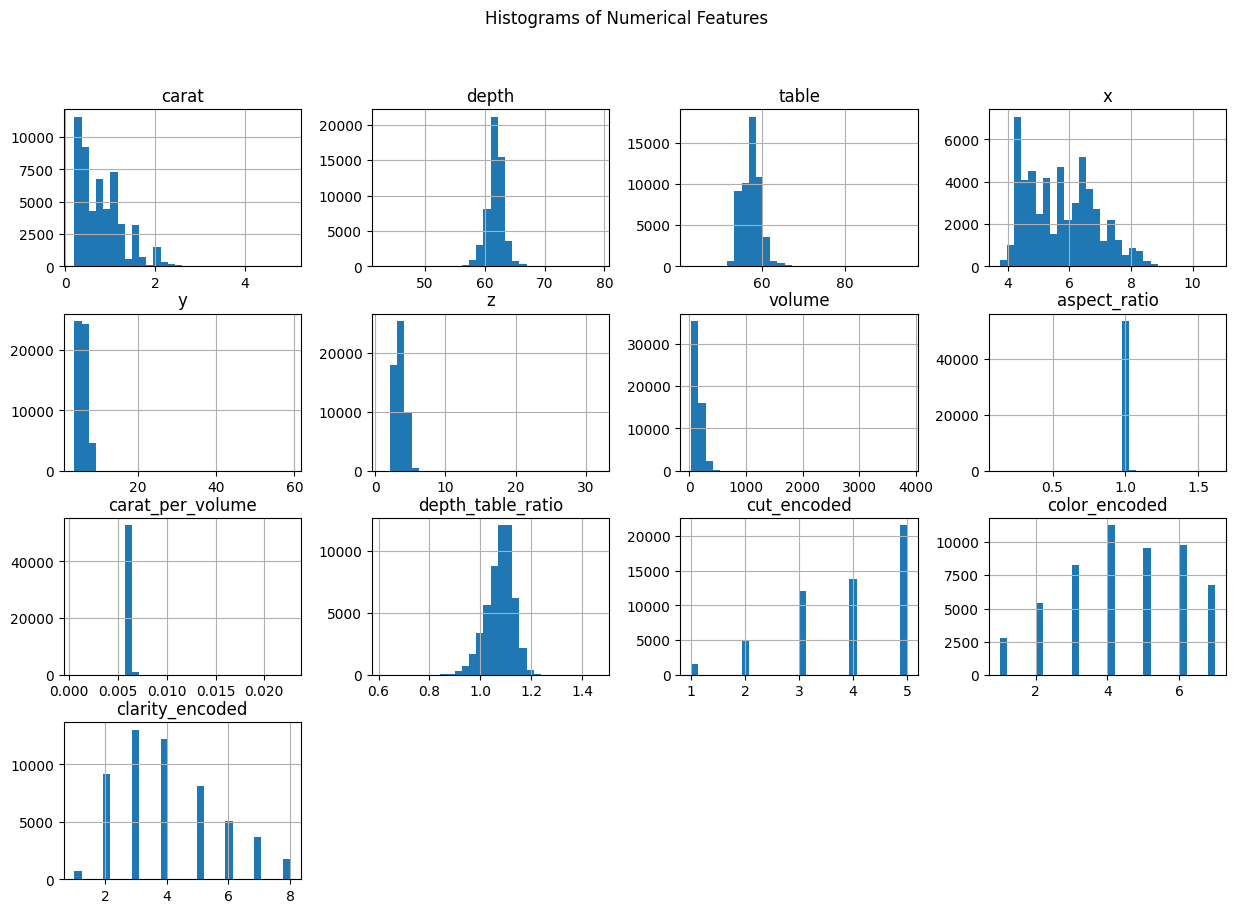

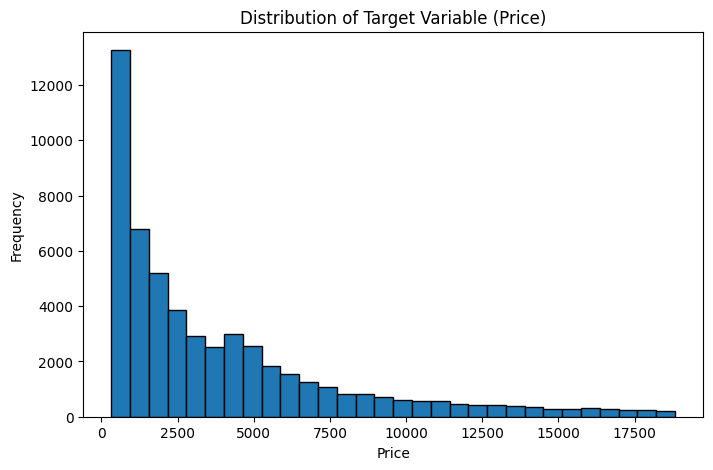

In [108]:
df[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(df[target_column], bins=30, edgecolor="black")
plt.title("Distribution of Target Variable (Price)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


### Scatterplots numerical features against price

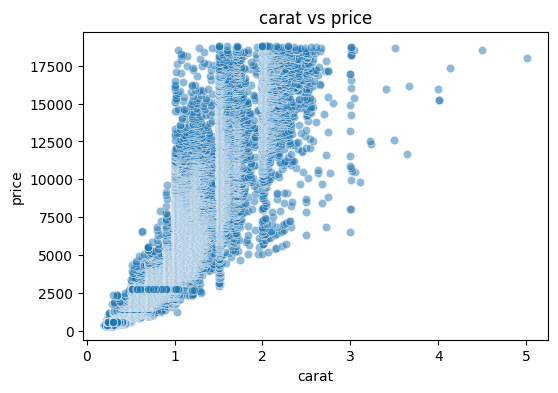

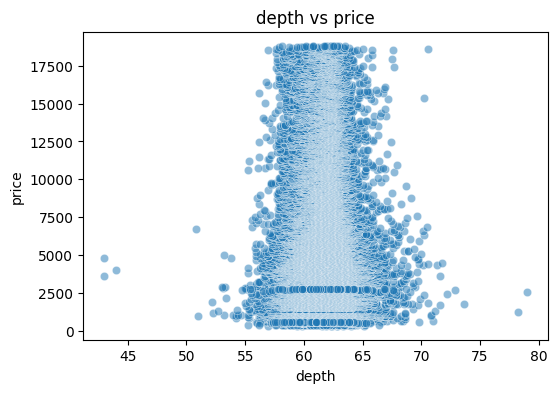

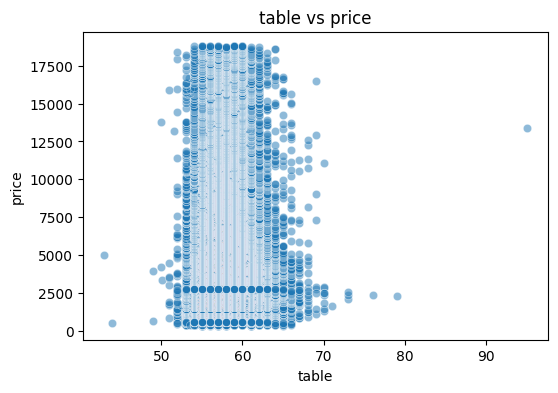

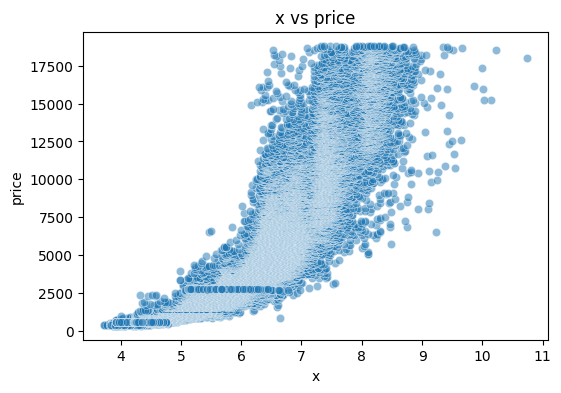

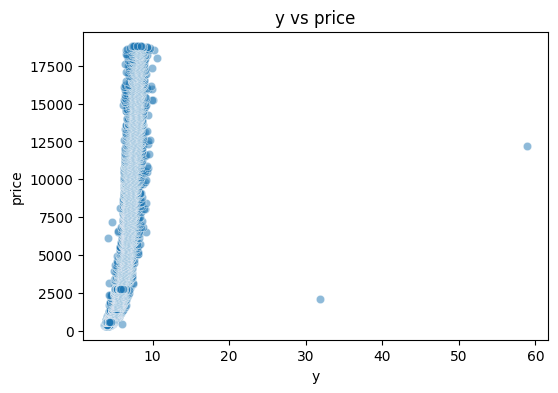

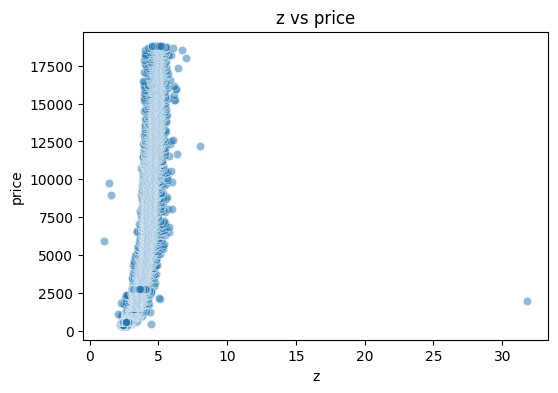

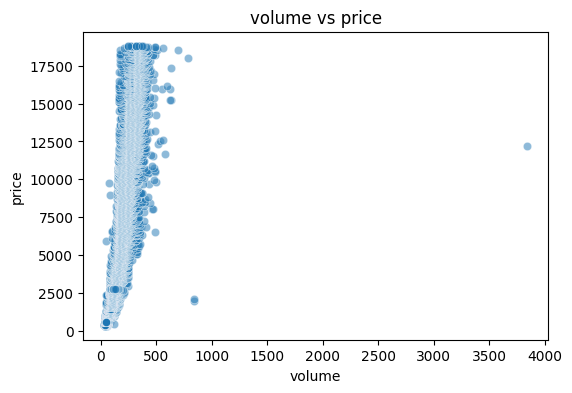

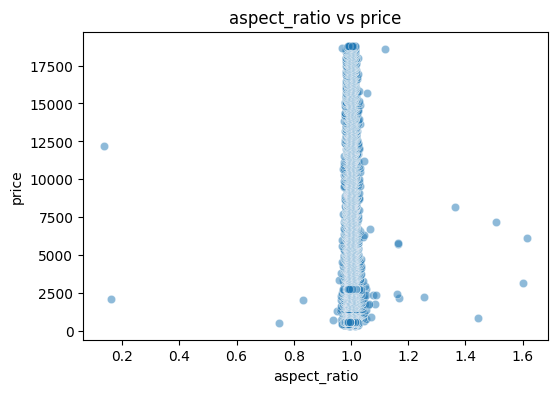

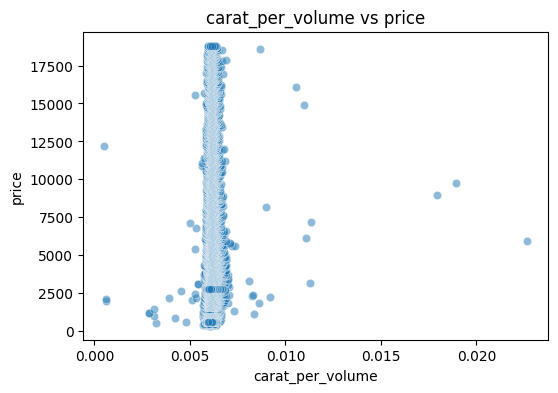

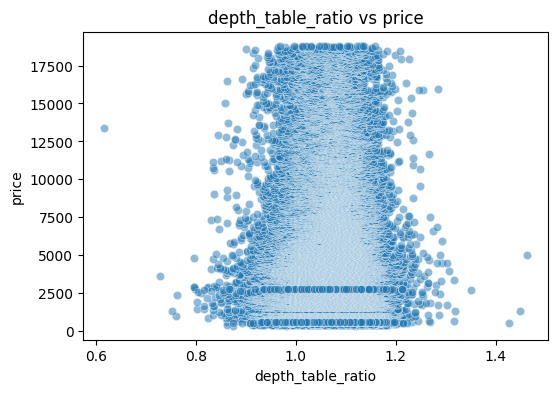

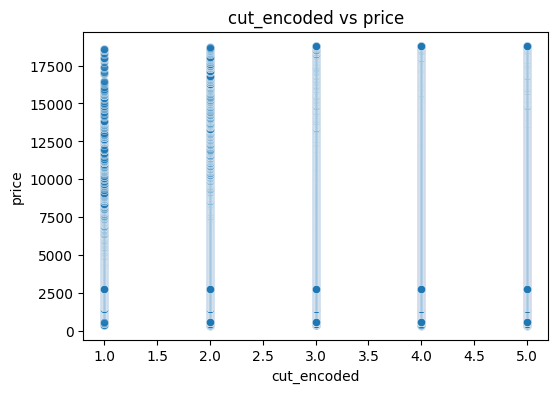

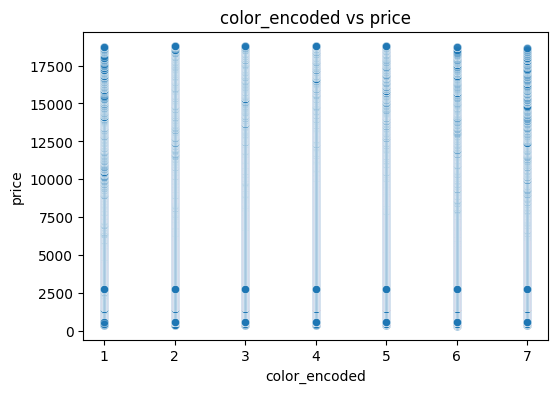

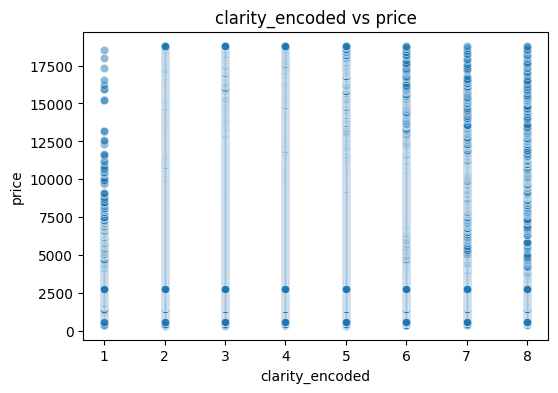

In [109]:
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    # sns.scatterplot(x=col, y=target_column, data=df, alpha=0.5)
    # sns.regplot(
    #     x=col,
    #     y=target_column,
    #     data=df,
    #     scatter_kws={"alpha": 0.4},
    #     line_kws={"color": "red"},
    # )
    sns.scatterplot(x=col, y=target_column, data=df, alpha=0.5)
    plt.title(f"{col} vs {target_column}")
    plt.show()


### Correlation Matrix

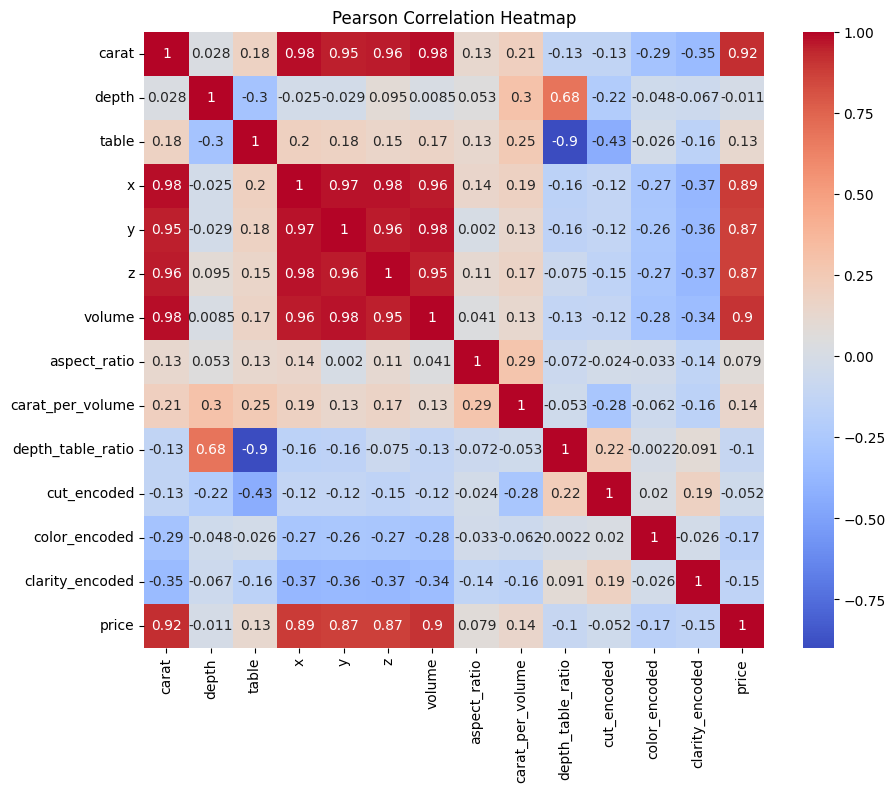

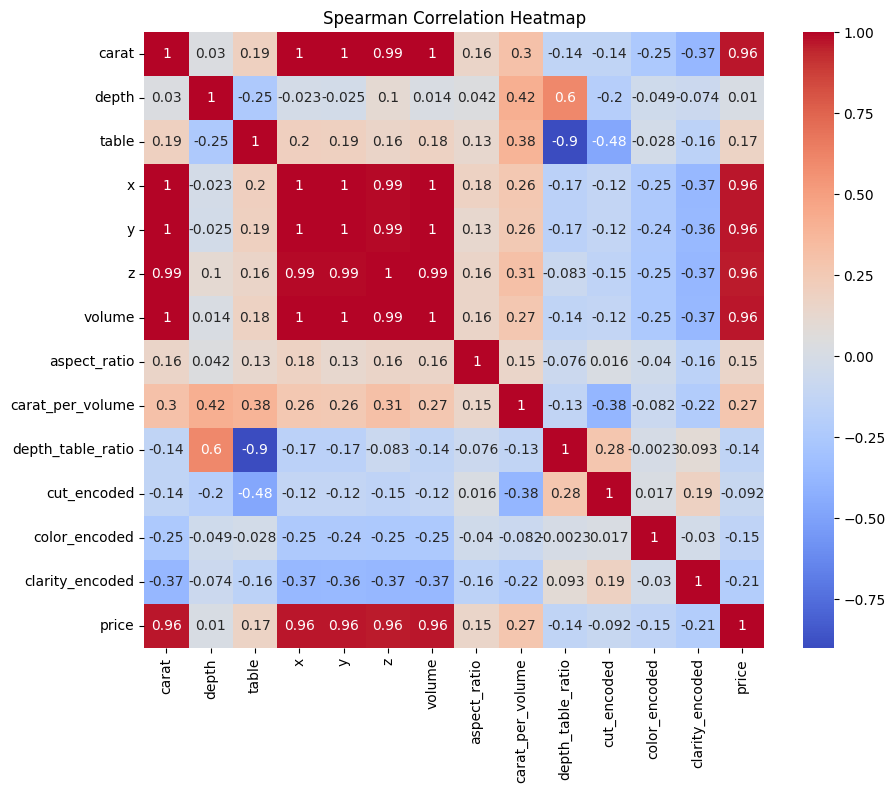

In [110]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_columns + [target_column]].corr(), annot=True, cmap="coolwarm")
plt.title("Pearson Correlation Heatmap")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[numerical_columns + [target_column]].corr(method="spearman"),
    annot=True,
    cmap="coolwarm",
)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [111]:
# Add a constant for the regression intercept
X_const = sm.add_constant(df[numerical_columns])

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

# Drop the constant row
vif_data = vif_data[vif_data["feature"] != "const"]

print(vif_data)

              feature         VIF
1               carat  325.001513
2               depth   57.194152
3               table  160.663889
4                   x  490.056901
5                   y  338.601735
6                   z   44.142721
7              volume  326.184588
8        aspect_ratio    3.165640
9    carat_per_volume    1.822961
10  depth_table_ratio  267.998365
11        cut_encoded    1.558681
12      color_encoded    1.120884
13    clarity_encoded    1.238606


### Cleaned Data

In [112]:
df_clean = df.copy()

# Remove zeros or negative values
df_clean = df_clean[
    (df_clean["x"] > 0)
    & (df_clean["y"] > 0)
    & (df_clean["z"] > 0)
    & (df_clean["carat"] > 0)
    & (df_clean["carat_per_volume"] > 0.0055)
    & (df_clean["price"] > 0)
]

# Keep only reasonable ranges
df_clean = df_clean[
    (df_clean["depth"].between(50, 75))
    & (df_clean["table"].between(50, 75))
    & (df_clean["aspect_ratio"].between(0.96, 1.04))
    & (df_clean["depth_table_ratio"].between(0.8, 1.3))
]

# Optional: remove extreme volume / aspect ratios
df_clean = df_clean[df_clean["volume"] < df_clean["volume"].quantile(0.99)]
df_clean = df_clean[
    df_clean["carat_per_volume"] < df_clean["carat_per_volume"].quantile(0.99)
]


print("Original size:", df.shape)
print("Cleaned size:", df_clean.shape)

Original size: (53775, 17)
Cleaned size: (52626, 17)


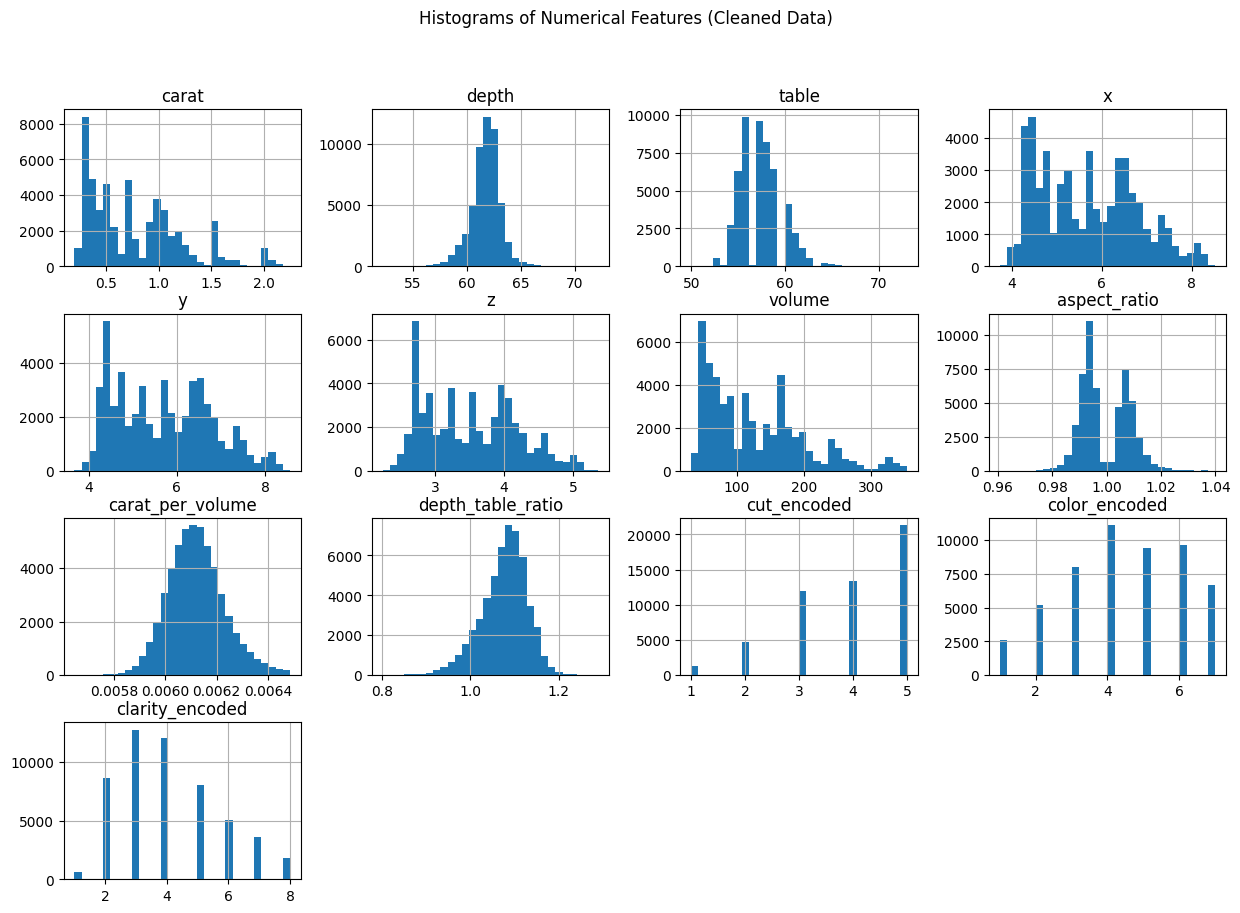

In [113]:
df_clean[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features (Cleaned Data)")
plt.show()

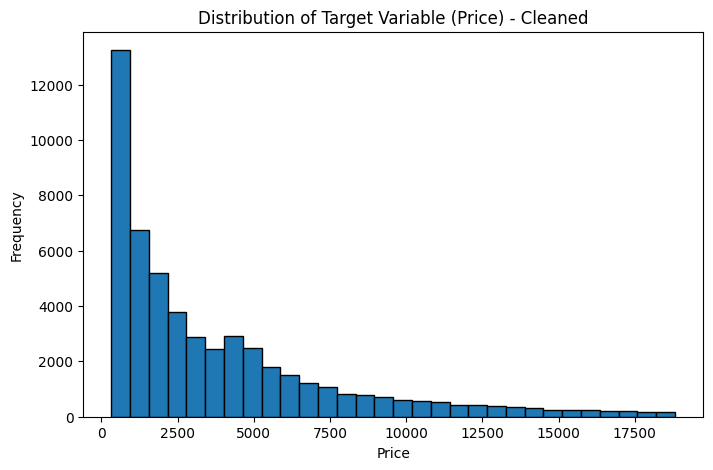

In [114]:
plt.figure(figsize=(8, 5))
plt.hist(df_clean[target_column], bins=30, edgecolor="black")
plt.title("Distribution of Target Variable (Price) - Cleaned")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

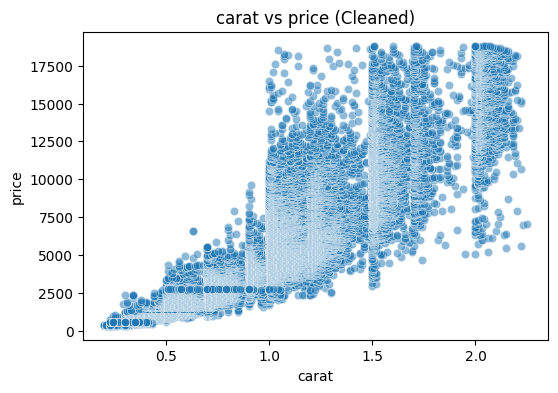

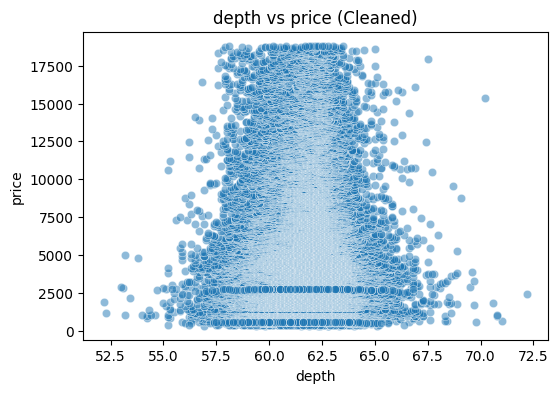

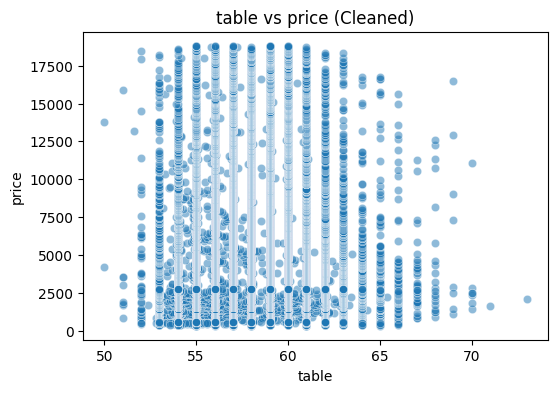

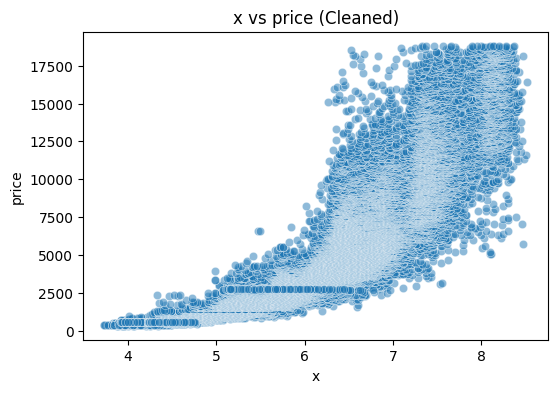

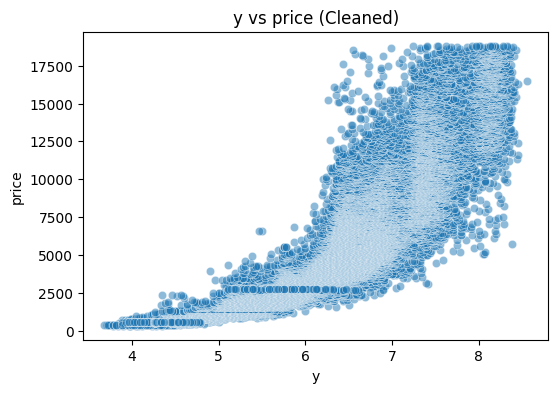

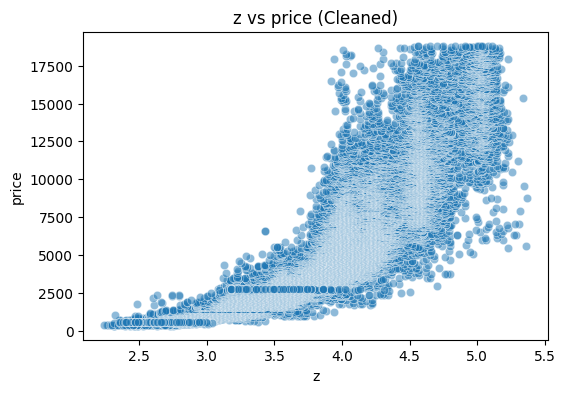

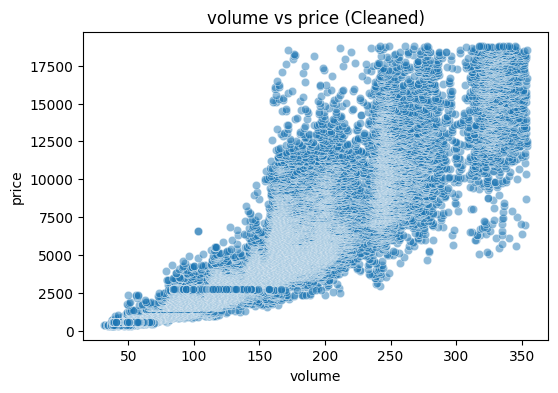

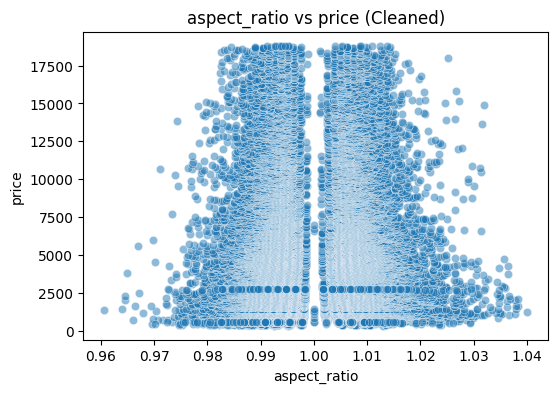

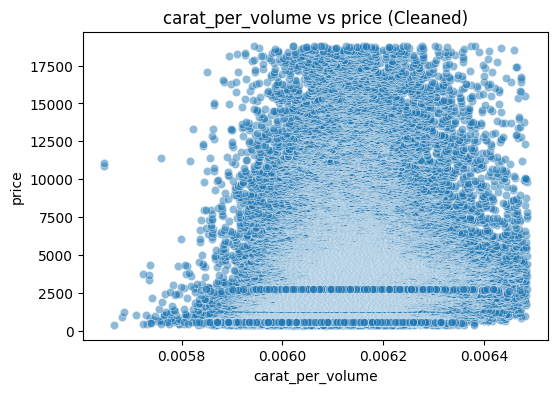

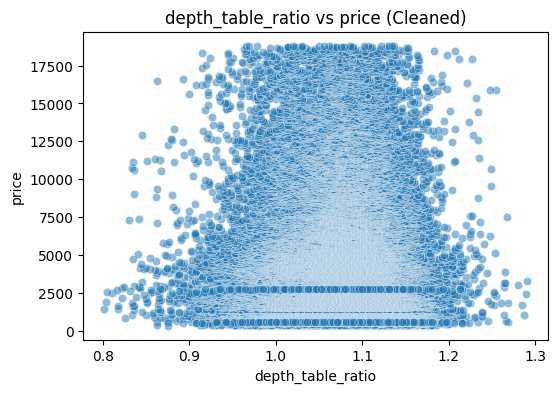

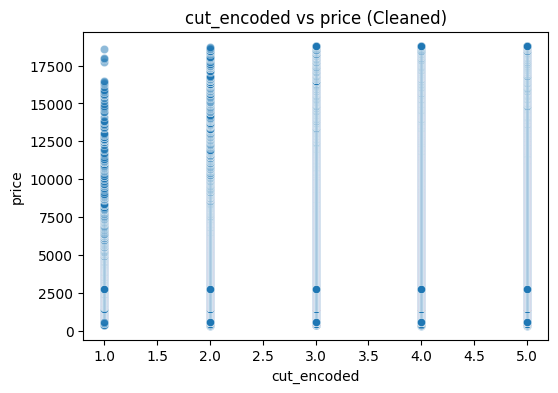

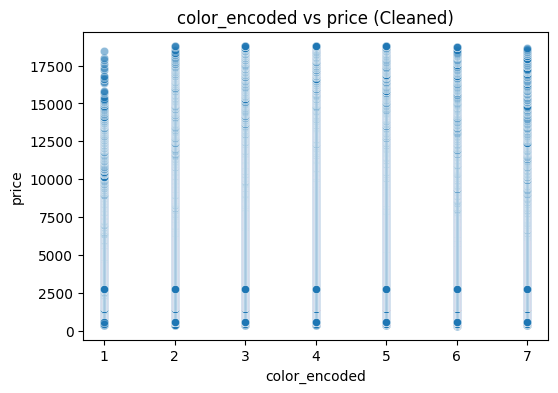

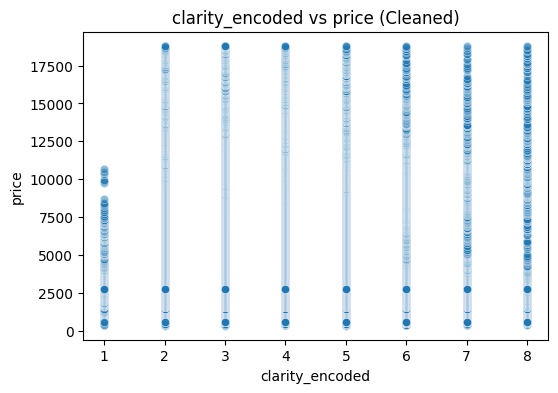

In [115]:
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    # sns.regplot(
    #     x=col,
    #     y=target_column,
    #     data=df_clean,
    #     scatter_kws={"alpha": 0.4},
    #     line_kws={"color": "red"},
    # )
    sns.scatterplot(x=col, y=target_column, data=df_clean, alpha=0.5)
    plt.title(f"{col} vs {target_column} (Cleaned)")
    plt.show()

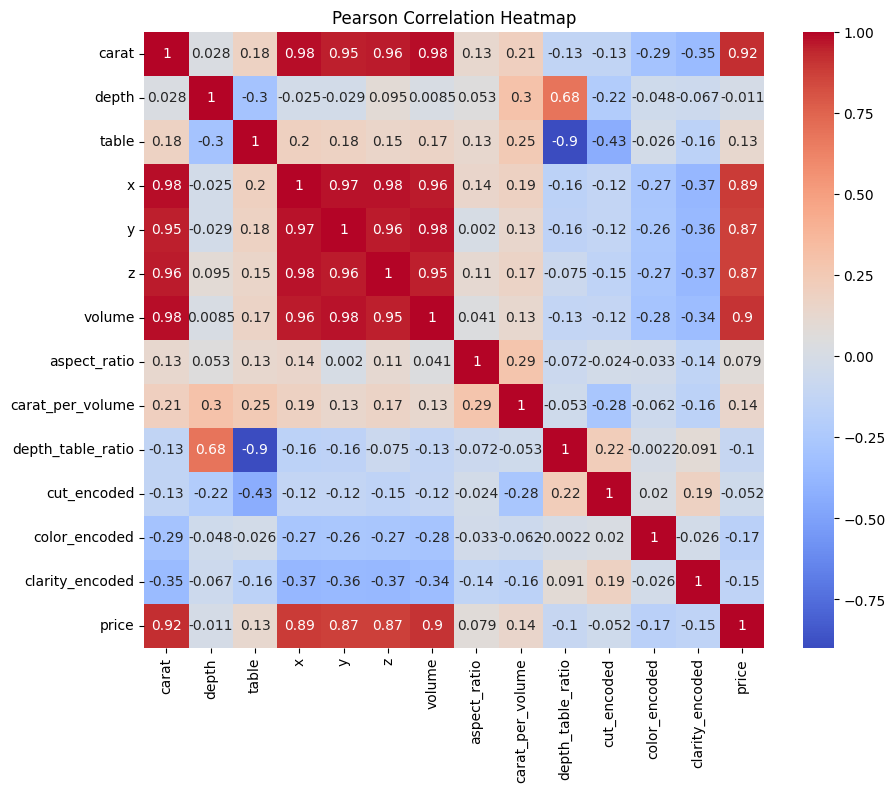

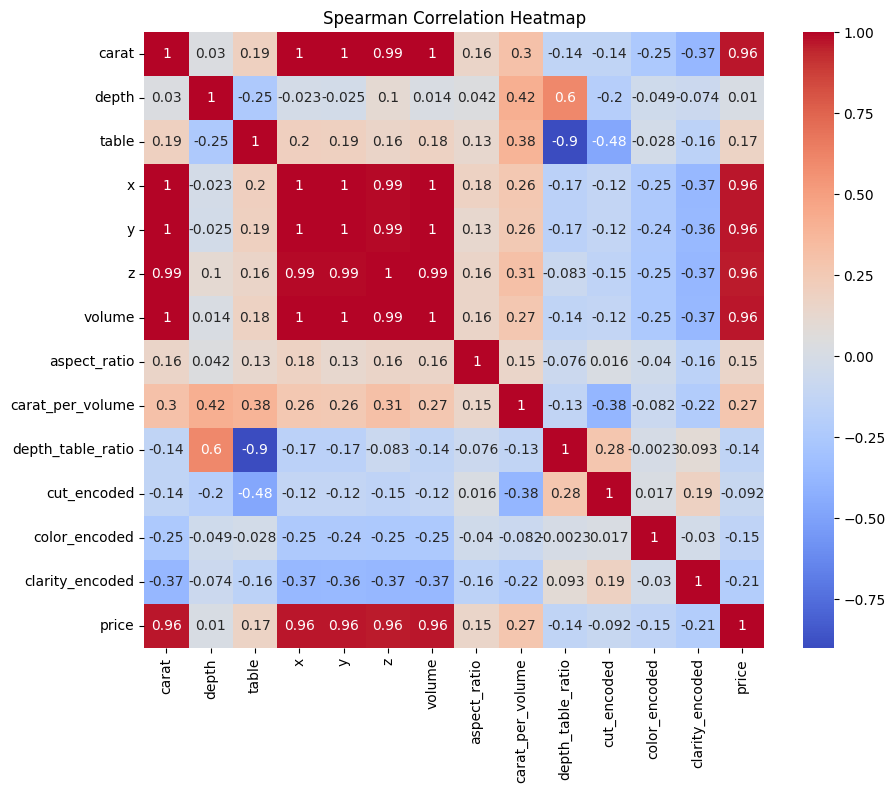

In [116]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_columns + [target_column]].corr(), annot=True, cmap="coolwarm")
plt.title("Pearson Correlation Heatmap")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[numerical_columns + [target_column]].corr(method="spearman"),
    annot=True,
    cmap="coolwarm",
)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [117]:
high_multicollinearity_columns_to_drop = ["x", "y", "z", "volume"]

low_corr_columns_to_drop = [
    "depth",
    "table",
    "aspect_ratio",
    "carat_per_volume",
    "depth_table_ratio",
    "cut_encoded",
    "color_encoded",
    "clarity_encoded"
]

df = df.drop(columns=high_multicollinearity_columns_to_drop, axis=1)
df_clean = df_clean.drop(columns=high_multicollinearity_columns_to_drop, axis=1)

numerical_columns = [
    col
    for col in numerical_columns
    if col not in high_multicollinearity_columns_to_drop
]

## Categorical EDA

In [118]:
# # Categorical EDA: countplot, boxplot, mean barplot side by side
# for col in categorical_columns:
#     order = sorted(category_orders[col], key=category_orders[col].get)

#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#     # Count plot
#     sns.countplot(x=col, data=df, order=order, ax=axes[0])
#     axes[0].set_title(f"Distribution of {col}")

#     # Boxplot vs price
#     sns.boxplot(x=col, y=target_column, data=df, order=order, ax=axes[1])
#     axes[1].set_title(f"{col} vs {target_column} (Boxplot)")

#     # Mean price barplot
#     sns.barplot(
#         x=col, y=target_column, data=df, order=order, estimator="mean", errorbar="sd", ax=axes[2]
#     )
#     axes[2].set_title(f"Mean {target_column} by {col}")

#     plt.tight_layout()
#     plt.show()


In [119]:
X = df_clean[numerical_columns]
y = df_clean[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# BIC

3 degrees is the best


In [120]:
# n = len(y_train)
# bic_scores = []

# for degree in range(1, 6):  # try polynomials 1–5
#     poly = PolynomialFeatures(degree=degree, include_bias=False)
#     X_poly = poly.fit_transform(X_train)

#     model = LinearRegression().fit(X_poly, y_train)
#     y_pred = model.predict(X_poly)

#     # Residual Sum of Squares
#     rss = np.sum((y_train - y_pred) ** 2)
#     k = X_poly.shape[1]  # number of parameters

#     # BIC calculation
#     bic = n * np.log(rss / n) + k * np.log(n)
#     bic_scores.append((degree, bic))

# print("BIC Scores:")
# for degree, bic in bic_scores:
#     print(f"Degree {degree}: {bic:.2f}")

# Model

In [121]:
degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [122]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

In [123]:
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

In [124]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [125]:
print(f"Train MSE: {train_mse:.2f}, Train R²: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.2f}, Test R²: {test_r2:.4f}")

Train MSE: 322952.74, Train R²: 0.9781
Test MSE: 332277.30, Test R²: 0.9770


# Visualising 3 degree with carat

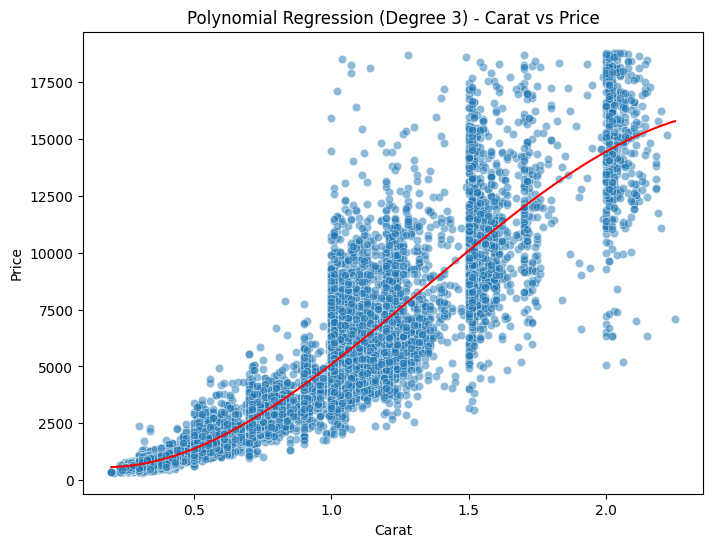

In [126]:
# Generate a smooth curve for carat vs predicted price
carat_vals = np.linspace(df_clean["carat"].min(), df_clean["carat"].max(), 200).reshape(
    -1, 1
)

# Use the same polynomial transformer
poly = PolynomialFeatures(degree=3, include_bias=False)
# Only using carat for visualization
carat_poly = poly.fit_transform(carat_vals)

# Predict using the fitted model (simplified single-feature visualization)

single_feature_model = LinearRegression().fit(
    poly.fit_transform(X_train[["carat"]]), y_train
)
carat_preds = single_feature_model.predict(carat_poly)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test["carat"], y=y_test, alpha=0.5)
plt.plot(carat_vals, carat_preds, color="red")
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Polynomial Regression (Degree 3) - Carat vs Price")
plt.show()